<a href="https://colab.research.google.com/github/Kitsunnneee/Contrastive-Learning/blob/main/Contrastive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [2]:
# Install torch geometric for point-cloud layers
import torch
version = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
try:
    import torch_geometric
except:
    !echo $version
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $version
    import torch_geometric

https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 35.6 MB/s et

In [2]:
from torch_geometric.datasets import ShapeNet
# Limit to 5000 samples, due to RAM restrictions
dataset = ShapeNet(root=".", categories=["Table", "Lamp", "Guitar", "Motorbike"]).shuffle()[:5000]
print("Number of Samples: ", len(dataset))
print("Sample: ", dataset[0])

Extracting ./shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Number of Samples:  5000
Sample:  Data(x=[2037, 3], y=[2037], pos=[2037, 3], category=[1])


In [3]:
dataset[0].pos

tensor([[-0.1447, -0.2850,  0.0989],
        [-0.0127,  0.3402,  0.1909],
        [-0.1073, -0.3404,  0.0106],
        ...,
        [ 0.0484,  0.3040,  0.1467],
        [ 0.0292, -0.2935,  0.1563],
        [ 0.2208, -0.3557, -0.1702]])

In [4]:
!pip install plotly --quiet
import plotly.express as px

def plot_3d_shape(shape):
    print("Number of data points: ", shape.x.shape[0])
    x = shape.pos[:, 0]
    y = shape.pos[:, 1]
    z = shape.pos[:, 2]
    fig = px.scatter_3d(x=x, y=y, z=z, opacity=0.3)
    fig.show()

# Pick a sample
sample_idx = 3
plot_3d_shape(dataset[sample_idx])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
Number of data points:  2827


In [5]:
# Let's check the distribution of classes
cat_dict = {key: 0 for key in dataset.categories}
for datapoint in dataset: cat_dict[dataset.categories[datapoint.category.int()]]+=1
cat_dict

{'Table': 3425, 'Lamp': 971, 'Guitar': 489, 'Motorbike': 115}

In [11]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

augmentation = T.Compose([T.RandomJitter(0.03), T.RandomFlip(1), T.RandomShear(0.2)])

In [12]:
# Original data point
sample = next(iter(data_loader))
plot_3d_shape(sample[0])

Number of data points:  2642


In [13]:
# Augmented data point
transformered = augmentation(sample)
plot_3d_shape(transformered[0])

Number of data points:  2642


In [14]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool


class Model(torch.nn.Module):
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        # Feature extraction
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        # Encoder head
        self.lin1 = Linear(128 + 64, 128)
        # Projection head (See explanation in SimCLRv2)
        self.mlp = MLP([128, 256, 32], norm=None)

    def forward(self, data, train=True):
        if train:
            # Get 2 augmentations of the batch
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)

            # Extract properties
            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            # Get representations for first augmented view
            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2], dim=1))

            # Get representations for second augmented view
            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2], dim=1))

            # Global representation
            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            h_points = self.lin1(torch.cat([x1, x2], dim=1))
            return global_max_pool(h_points, data.batch)

        # Transformation for loss function
        compact_h_1 = self.mlp(h_1)
        compact_h_2 = self.mlp(h_2)
        return h_1, h_2, compact_h_1, compact_h_2

In [15]:
!pip install pytorch-metric-learning -q

from pytorch_metric_learning.losses import NTXentLoss
loss_func = NTXentLoss(temperature=0.10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [17]:
import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        # Get data representations
        h_1, h_2, compact_h_1, compact_h_2 = model(data)
        # Prepare for loss
        embeddings = torch.cat((compact_h_1, compact_h_2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(dataset)

for epoch in range(1, 4):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 157/157 [06:08<00:00,  2.35s/it]


Epoch 001, Loss: 1.4772


100%|██████████| 157/157 [06:09<00:00,  2.35s/it]


Epoch 002, Loss: 0.7718


100%|██████████| 157/157 [06:09<00:00,  2.35s/it]

Epoch 003, Loss: 0.5514


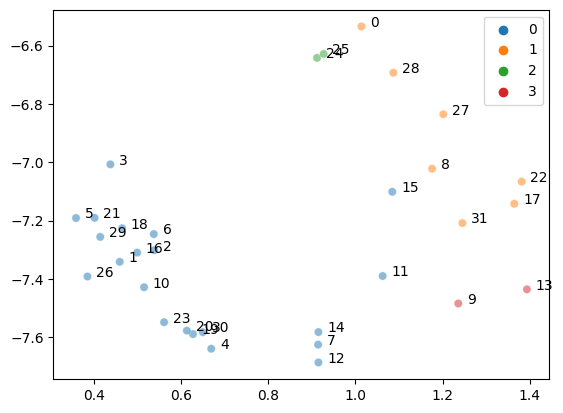

In [19]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get sample batch
sample = next(iter(data_loader))

# Get representations
h = model(sample.to(device), train=False)
h = h.cpu().detach()
labels = sample.category.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels,
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]),
            pd.Series(h_embedded[:,1]),
            pd.Series(annotations),
            plt.gca())